In [1]:
#### Tratamiento de datos ####
import pandas as pd
import numpy as np

#### Graficos ####
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#### Preprocesamiento y modelamiento ####
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
#from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from joblib import Parallel, delayed,cpu_count
import optuna

#### Otros ####
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format

In [2]:
def inspeccionar_valores_nulos(df):
    # Inspección de valores nulos
    nulos = pd.DataFrame(df.isna().sum().reset_index())
    nulos = nulos.rename(columns={"index": "Variable", 0: "Nulos"})
    
    # Calcular el porcentaje de nulos
    nulos['Porcentaje Nulos'] = (nulos['Nulos'] / len(df)) * 100
    
    # Ordenar por número de nulos en orden descendente
    nulos = nulos.sort_values(by='Nulos', ascending=False)
    
    # Mostrar el resultado
    #print(nulos)
    
    return nulos

In [3]:
def get_column_types(df):
    """
    Returns two lists: one with the names of categorical columns and another with the names of numeric columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    tuple: A tuple containing two lists - (categorical_columns, numeric_columns).
    """
    categorical_columns = df.select_dtypes(include='object').columns.tolist()
    numeric_columns = df.select_dtypes(include='number').columns.tolist()
    
    return categorical_columns, numeric_columns

In [4]:
def replace_nulls_with_mode_auto(df):
    """
    Replaces null values in categorical columns of a DataFrame with the mode of each column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: DataFrame with null values replaced by mode in categorical columns.
    """
    categorical_columns = df.select_dtypes(include='object').columns
    
    for column in categorical_columns:
        mode_value = df[column].mode()[0]  # mode() returns a Series, take the first mode value
        df[column].fillna(mode_value, inplace=True)
    
    #return df

In [5]:
def replace_nulls_with_median_auto(df):
    """
    Replaces null values in numeric columns of a DataFrame with the median of each column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: DataFrame with null values replaced by median in numeric columns.
    """
    numeric_columns = df.select_dtypes(include='number').columns
    
    for column in numeric_columns:
        median_value = df[column].median()
        df[column].fillna(median_value, inplace=True)
    
    #return df

In [6]:
datos = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", engine='c')

In [39]:
df= datos.copy()

In [40]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [42]:
df['SeniorCitizen'] = df['SeniorCitizen'].replace({0:'No', 1:'Yes'}).astype('object')
df['Churn'] = df['Churn'].replace({'No':0, 'Yes':1}).astype('int')

In [44]:
df['TotalCharges'] = df['TotalCharges'].replace({'':0,' ':0})

In [45]:
df['TotalCharges'] = df['TotalCharges'].astype('float')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [48]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [49]:
df.shape

(7043, 21)

In [50]:
#inspección de valores nulos
inspeccionar_valores_nulos(df)

,Variable,Nulos,Porcentaje Nulos
0,customerID,0,0.00
11,DeviceProtection,0,0.00
19,TotalCharges,0,0.00
18,MonthlyCharges,0,0.00
17,PaymentMethod,0,0.00
16,PaperlessBilling,0,0.00
15,Contract,0,0.00
14,StreamingMovies,0,0.00
13,StreamingTV,0,0.00
12,TechSupport,0,0.00


In [51]:
df.drop('customerID',axis=1,inplace=True)

In [52]:
#Principales estadisticas del df
df.describe()

,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.00,7043.00,7043.00,7043.00
mean,32.37,64.76,2279.73,0.27
std,24.56,30.09,2266.79,0.44
min,0.00,18.25,0.00,0.00
25%,9.00,35.50,398.55,0.00
50%,29.00,70.35,1394.55,0.00
75%,55.00,89.85,3786.60,1.00
max,72.00,118.75,8684.80,1.00


In [53]:
#distribucion de la variable default
df.Churn.value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

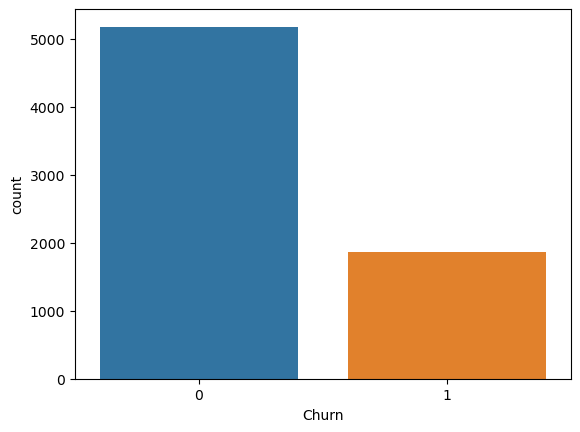

In [54]:
sns.countplot(x="Churn", data=df)
plt.show()

In [55]:
media_default=df.Churn.mean().round(4)
media_default

0.2654

In [56]:
#listas con variables numericas y categoricas
categorical_columns, numeric_columns = get_column_types(df)

In [57]:
len(categorical_columns),len(numeric_columns)

(16, 4)

In [58]:
numeric_columns.remove('Churn')

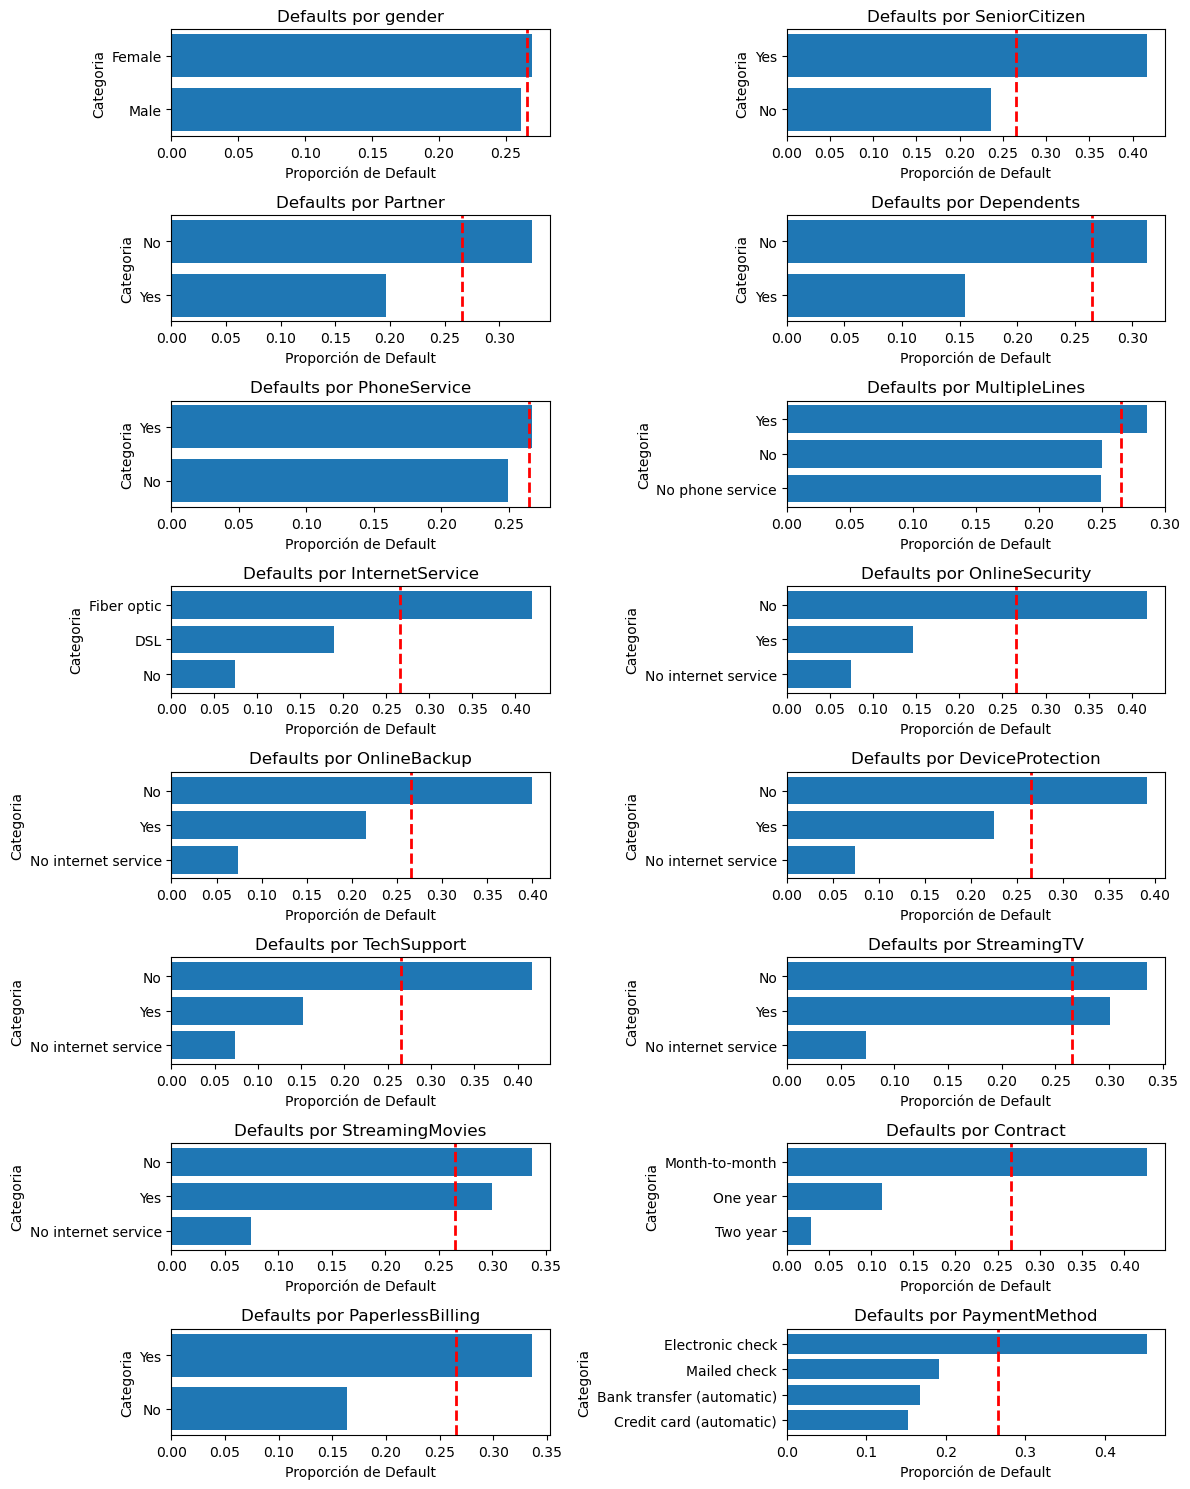

In [59]:
fig, axes = plt.subplots(8, 2, figsize=(12,15))  # 4 filas y 2 columnas

for i, category in enumerate(categorical_columns):
    if i >= len(axes.flatten()):
        break
    ax = axes.flatten()[i]
    grouped_data = df.groupby(category)['Churn'].mean().sort_values(ascending=True)
    ax.barh(grouped_data.index, grouped_data.values)
    ax.set_xlabel('Proporción de Default')
    ax.set_ylabel('Categoria')
    ax.set_title(f'Defaults por {category}')
    
        # Agregar la línea del promedio
    ax.axvline(media_default, color='red', linestyle='--', linewidth=2, label=f'Prom.: {media_default:.2f}')

# Eliminar los gráficos vacíos si hay menos de 8 categorías
if len(categorical_columns) < len(axes.flatten()):
    for j in range(len(categorical_columns), len(axes.flatten())):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

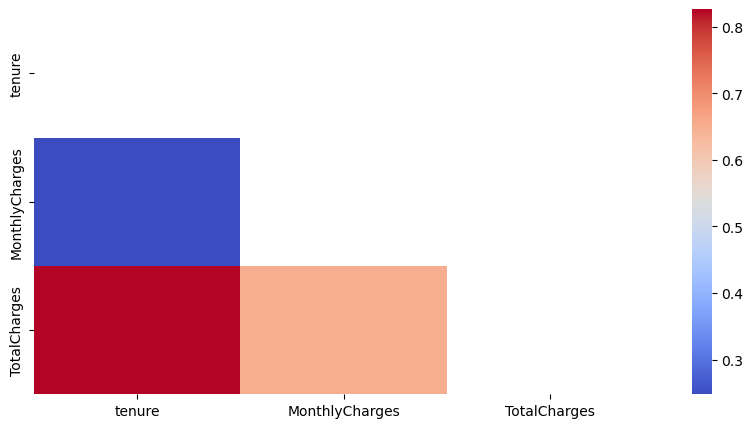

In [60]:
plt.figure(figsize= (10,5))
correlaciones = df[numeric_columns].corr()
upp_mat = np.triu(correlaciones)
sns.heatmap(correlaciones, annot = True, cmap = 'coolwarm', mask = upp_mat,annot_kws={"size": 2})
plt.show()

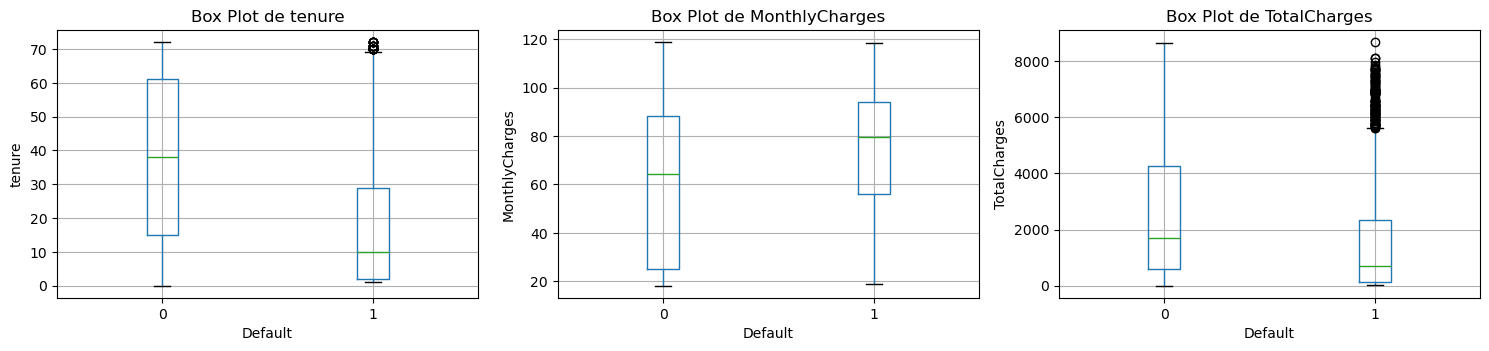

In [61]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # 6 filas y 2 columnas

for i, var in enumerate(numeric_columns):
    if i >= len(axes.flatten()):
        break
    ax = axes.flatten()[i]
    df.boxplot(column=var, by='Churn', ax=ax)
    ax.set_title(f'Box Plot de {var}')
    ax.set_xlabel('Default')
    ax.set_ylabel(var)

# Eliminar los gráficos vacíos si hay menos de 12 gráficos
if len(numeric_columns) < len(axes.flatten()):
    for j in range(len(numeric_columns), len(axes.flatten())):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.suptitle('')  # Eliminar el título general que añade pandas por defecto
plt.show()

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns = 'Churn'),
                                        df['Churn'],
                                        random_state = 123,
                                        stratify=df['Churn']
                                    )

In [63]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1487,Female,No,No,No,56,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Electronic check,106.80,5914.40
1485,Male,Yes,No,No,22,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,96.70,2082.95
4731,Male,No,Yes,Yes,19,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.90,357.70
5987,Female,No,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.35,20.35
5058,Female,No,No,No,30,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,48.80,1536.75


In [64]:
#listas con variables numericas y categoricas
categorical_columns, numeric_columns = get_column_types(X_train)

In [65]:
# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'), categorical_columns)],
                    remainder='passthrough',
                    verbose_feature_names_out=False
               ).set_output(transform="pandas")

In [66]:
# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [67]:
X_train_prep.head()

,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
1487,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,56,106.80,5914.40
1485,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,22,96.70,2082.95
4731,1.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,19,19.90,357.70
5987,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1,20.35,20.35
5058,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,30,48.80,1536.75


In [74]:
X_train_prep.shape[1]

40

In [75]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {
    'n_estimators': [150],
    'max_features': [5, 7, 9, 11, 13, 15, 17,20],
    'max_depth'   : [None, 4, 6, 8, 10, 12],
    'criterion'   : ['gini']
}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X=X_train_prep, y=y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex='(param*|mean_t|std_t)') \
    .drop(columns='params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
26,gini,8,9,150,0.80,0.01,0.85,0.00
29,gini,8,15,150,0.80,0.01,0.86,0.00
22,gini,6,17,150,0.80,0.01,0.83,0.00
21,gini,6,15,150,0.80,0.01,0.82,0.00


In [76]:
# Mejores hiperparámetros encontrados por validación cruzada
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados por (cv)")
print("--------------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

--------------------------------------------
Mejores hiperparámetros encontrados por (cv)
--------------------------------------------
{'criterion': 'gini', 'max_depth': 8, 'max_features': 9, 'n_estimators': 150} : 0.8026637591621034 accuracy


In [77]:
# Modelo con los mejores hiperparámetros
# ==============================================================================
modelo_final = grid.best_estimator_
modelo_final

RandomForestClassifier(max_depth=8, max_features=9, n_estimators=150,
                       random_state=123)

In [78]:
# Error de test del modelo final
# ==============================================================================
predicciones = modelo_final.predict(X=X_test_prep)

In [79]:
mat_confusion = confusion_matrix(y_true=y_test, y_pred=predicciones)
mat_confusion

array([[1186,  108],
       [ 243,  224]], dtype=int64)

In [80]:
print(classification_report(
        y_true = y_test,
        y_pred = predicciones))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1294
           1       0.67      0.48      0.56       467

    accuracy                           0.80      1761
   macro avg       0.75      0.70      0.72      1761
weighted avg       0.79      0.80      0.79      1761



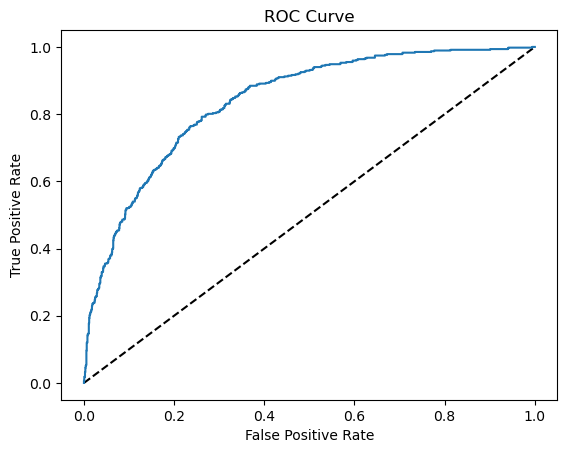

In [81]:
# Generate ROC curve values: fpr, tpr, thresholds

#Predicting proba
y_pred_prob =modelo_final.predict_proba(X_test_prep)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [88]:
# Importancia de los predictores basada en permutación
# ==============================================================================
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train_prep,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train_prep.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
37,0.05,0.00,tenure
29,0.03,0.00,Contract_Month-to-month
39,0.03,0.00,TotalCharges
9,0.02,0.00,InternetService_Fiber optic
38,0.02,0.00,MonthlyCharges
20,0.01,0.00,TechSupport_No
35,0.01,0.00,PaymentMethod_Electronic check
11,0.01,0.00,OnlineSecurity_No
32,0.01,0.00,PaperlessBilling_Yes
8,0.01,0.00,InternetService_DSL


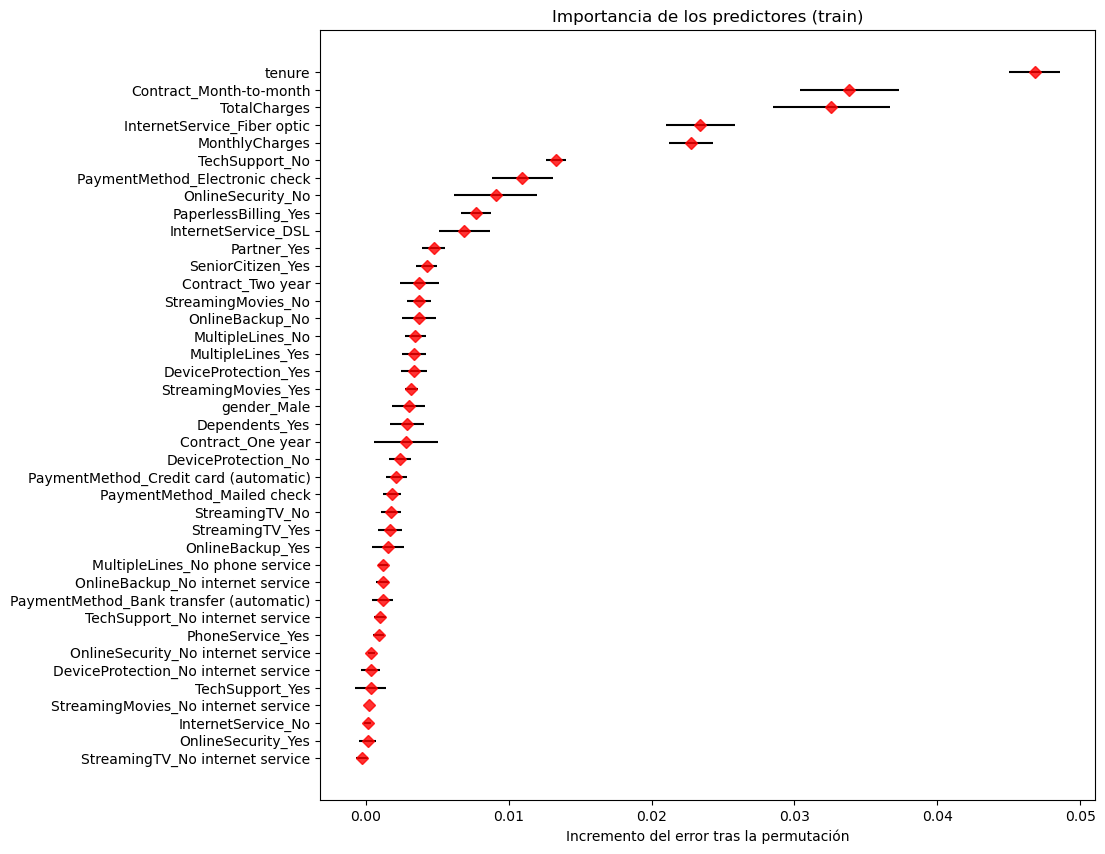

In [83]:
# Gráfico de la importancia de cada predictor
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 10))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

In [86]:
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import multiprocessing

In [89]:
# Define un espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators':  [150],
    'learning_rate': [0.02, 0.05, 0.1],
    'subsample':     [0.6, 0.7, 0.8],
    'max_depth':     [5, 6, 7, 8],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [2, 3, 4],
    'gamma': [0.1,0.2, 0.3, 0.4]
}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
            estimator  = XGBClassifier(random_state=123),
            param_grid = param_grid,
            scoring    = 'accuracy',
            n_jobs     = multiprocessing.cpu_count() - 1,
            cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
            refit      = True,
            verbose    = 0,
            return_train_score = True
       )

grid.fit(X = X_train_prep, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
440,0.90,0.10,0.02,5,4,150,0.80,0.81,0.01,0.83,0.00
980,1.00,0.20,0.02,5,4,150,0.80,0.81,0.01,0.83,0.00
761,0.90,0.40,0.02,5,3,150,0.80,0.81,0.01,0.83,0.00
437,0.90,0.10,0.02,5,3,150,0.80,0.81,0.01,0.83,0.00


In [90]:
# Mejores hiperparámetros encontrados por validación cruzada
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados por (cv)")
print("--------------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

--------------------------------------------
Mejores hiperparámetros encontrados por (cv)
--------------------------------------------
{'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 150, 'subsample': 0.8} : 0.8060716555335762 accuracy


In [91]:
# Modelo con los mejores hiperparámetros
# ==============================================================================
modelo_final = grid.best_estimator_
modelo_final

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [92]:
# Error de test del modelo final
# ==============================================================================
predicciones = modelo_final.predict(X=X_test_prep)

In [93]:
mat_confusion = confusion_matrix(y_true=y_test, y_pred=predicciones)
mat_confusion

array([[1181,  113],
       [ 244,  223]], dtype=int64)

In [94]:
print(classification_report(
        y_true = y_test,
        y_pred = predicciones))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1294
           1       0.66      0.48      0.56       467

    accuracy                           0.80      1761
   macro avg       0.75      0.70      0.71      1761
weighted avg       0.78      0.80      0.79      1761



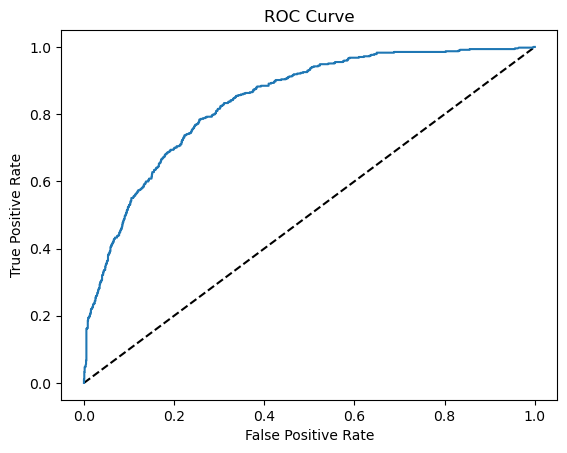

In [95]:
# Generate ROC curve values: fpr, tpr, thresholds

#Predicting proba
y_pred_prob =modelo_final.predict_proba(X_test_prep)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()